In [18]:
import re
from Bio import SwissProt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=20)

In [8]:
# List of features that can be be found in Swiss-prot records
FEATURE_TYPES = ['ACT_SITE',
                 'BINDING',
                 'CA_BIND',
                 'CHAIN',
                 'COILED',
                 'COMPBIAS',
                 'CONFLICT',
                 'CROSSLNK',
                 'DISULFID',
                 'DNA_BIND',
                 'DOMAIN',
                 'INIT_MET',
                 'INTRAMEM',
                 'LIPID',
                 'METAL',
                 'MOD_RES',
                 'MOTIF',
                 'MUTAGEN',
                 'NON_STD',
                 'NP_BIND',
                 'PEPTIDE',
                 'PROPEP',
                 'REGION',
                 'REPEAT',
                 'SIGNAL',
                 'SITE',
                 'TOPO_DOM',
                 'TRANSMEM',
                 'TURN',
                 'VARIANT',
                 'STRAND',
                 'VAR_SEQ',
                 'HELIX',
                 'ZN_FING',
                 'POLYPROLINES']

In [9]:
def find_polyproline_motifs(sequence):
    """Returns a list of indices where polyproline motifs are located"""
    matches = []
    for match in re.finditer(r"PP+", sequence):
        matches += [*range(*match.span())]
    return matches


def get_pp_motif_positions(sequence):
    """Returns a list of polyproline motifs starting positions"""
    matches = []
    idx = 0
    while idx != len(sequence):
        match = re.match(r"PP+", sequence[idx:])
        if match:
            matches.append(idx)
            idx += match.end()
        else:
            idx += 1
    return matches


def get_single_motif_positions(sequence):
    """Returns a list of single prolines starting positions"""
    matches = []
    idx = 0
    while idx != len(sequence):
        match = re.match(r"[^P]P[^P]", sequence[idx:])
        if match:
            matches.append(idx + 1)
            idx += match.end()
        else:
            idx += 1
    return matches


def polyproline_overlap_mask(feature_map, feature):
    """Returns a bitmask where 1 represent overlap between polyproline
    motif and given 'feature'"""
    overlap = data[feature] + data.POLYPROLINES
    return overlap == data[feature].max() + data.POLYPROLINES.max()


def count_bitmask_seqs(pp_mask):
    """Returns number of contiguous sequences in bitmap"""
    count = 0
    status = False
    for idx, i in enumerate(pp_mask):
        if i:
            status = True
        if (not i and status) or (i and idx == len(pp_mask) - 1):
            count += 1
            status = False
    return count


def get_rel_pp_position(record, target_feature):
    """Returns relative positions of polyproline motifs in given 'feature' if there are any"""
    motif_feature_positions = []
    motif_position = find_polyproline_motifs(record.sequence)
    for feature in record.features:
        if feature.type == target_feature:
            feature_location = {*feature.location}
            overlap = set(motif_position) & feature_location
            if overlap:
                motif_feature_positions.append((min(overlap) - feature.location.start) / len(feature_location))
    return motif_feature_positions


def get_disord_locations(record):
    """Returns coordinates of disordered regions"""
    start = 0
    secondary_loc = []
    disord_loc = []
    for feature in record.features:
        if feature.type in {"HELIX", "STRAND", "TURN"}:
            feature_location = [*feature.location]
            secondary_loc.append(feature_location)
    for loc in secondary_loc:
        disord_loc.append(set(range(start, loc[0])))
        start = loc[-1] + 1
    disord_loc.append(set(range(start, record.sequence_length)))
    return disord_loc
        

def get_rel_pp_position_disord(record):
    """Returns relative positions of polyproline motifs in given 'feature' if there are any"""
    motif_feature_positions = []
    motif_position = find_polyproline_motifs(record.sequence)
    for loc in get_disord_locations(record):
        overlap = set(motif_position) & loc
        if overlap and len(loc) >= 4:
            motif_feature_positions.append((min(overlap) - min(loc)) / (max(loc) - min(loc)))
    return motif_feature_positions

In [10]:
def proline_feature_map_generator(file, thresh_coverage=0.8):
    """Parses swissprot proteome file. Only sequences with coverage of 3d structures
    greater than 'thresh_coverage' are used.
    Generator yields feature_map which is collection (DataFrame) of bitmasks
    for every feature and record itself"""
    for record in SwissProt.parse(file):
        try:
            motif_map = find_polyproline_motifs(record.sequence)
            if motif_map and get_pdb_coverage(record) > thresh_coverage:
                feature_map = pd.DataFrame(np.zeros((len(record.sequence), len(FEATURE_TYPES))), columns=FEATURE_TYPES, dtype="uint8")
                for feature in record.features:
                    feature_map.loc[[*feature.location], feature.type] = FEATURE_TYPES.index(feature.type) / len(FEATURE_TYPES)
                feature_map.loc[motif_map, "POLYPROLINES"] = 1
                yield feature_map, record
        except TypeError:
            pass
        
def get_pdb_coverage(record):
    """Calculates coverage of sequence with 3d structures. Possible 
    values are in the interval [0, +inf)"""
    pdb_refs = filter(lambda x: "PDB" == x[0], record.cross_references)
    structure_coverages_str = map(lambda x: x[-1].split("=")[-1].split("-"), pdb_refs)
    structure_coverages_int = map(lambda x: int(x[1]) - int(x[0]), structure_coverages_str)
    return sum(structure_coverages_int) / record.sequence_length

## Interactive view

In [11]:
gen = proline_feature_map_generator("data/uniprot-proteome_UP000000625.txt")

MSEQETRGANEAIDFNDELRNRREKLAALRQQGVAFPNDFRRDHTSDQLHEEFDAKDNQELESLNIEVSVAGRMMTRRIMGKASFVTLQDVGGRIQLYVARDSLPEGVYNDQFKKWDLGDIIGARGTLFKTQTGELSIHCTELRLLTKALRPLPDKFHGLQDQEVRYRQRYLDLIANDKSRQTFVVRSKILAAIRQFMVARGFMEVETPMMQVIPGGASARPFITHHNALDLDMYLRIAPELYLKRLVVGGFERVFEINRNFRNEGISVRHNPEFTMMELYMAYADYHDLIELTESLFRTLAQEVLGTTKVTYGEHVFDFGKPFEKLTMREAIKKYRPETDMADLDNFDAAKALAESIGITVEKSWGLGRIVTEIFDEVAEAHLIQPTFITEYPAEVSPLARRNDVNPEITDRFEFFIGGREIGNGFSELNDAEDQAERFQEQVNAKAAGDDEAMFYDEDYVTALEYGLPPTAGLGIGIDRMIMLFTNSHTIRDVILFPAMRPQK


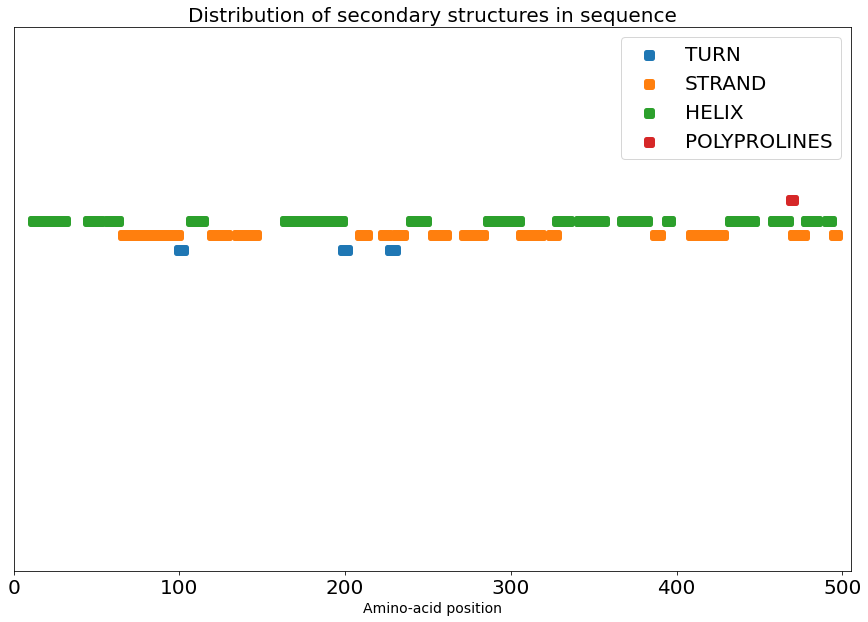

In [17]:
# Ctrl+Enter for interactive view of sequence structure

data, record = next(gen)
for feature in data:
    plt.axis((0, len(data), -0.5, 1.7))
    if feature == "POLYPROLINES":
        plot_data = data.loc[data[feature] > 0, feature]
        plt.scatter(plot_data.index, plot_data, lw=5, label=feature, marker="s")
    elif feature in {"HELIX", "TURN", "STRAND"}:
        plot_data = data.loc[data[feature] > 0, feature]
        plt.scatter(plot_data.index, plot_data, lw=5, label=feature, marker="s")
plt.xlabel("Amino-acid position", size=14)
plt.title("Distribution of secondary structures in sequence", size=20)
plt.yticks([], [])
plt.legend()
print(record.sequence)

Polyproline motifs are commonly found between secondary structures.

## Distribution of polyproline motifs in sequence

This shows the most frequent locations of polyproline motifs in terms of complete sequence length.

In [19]:
motif_positions = []
single_positions = []
for _, record in proline_feature_map_generator("data/uniprot-proteome_UP000000625.txt", thresh_coverage=-1):
    motif_positions.extend(list(map(lambda x: x / record.sequence_length, get_pp_motif_positions(record.sequence))))
    single_positions.extend(list(map(lambda x: x / record.sequence_length, get_single_motif_positions(record.sequence))))

In [20]:
plot_data = pd.DataFrame({"positions": motif_positions + single_positions,
                          "type": ["Motif"] * len(motif_positions) + ["Single"] * len(single_positions)})

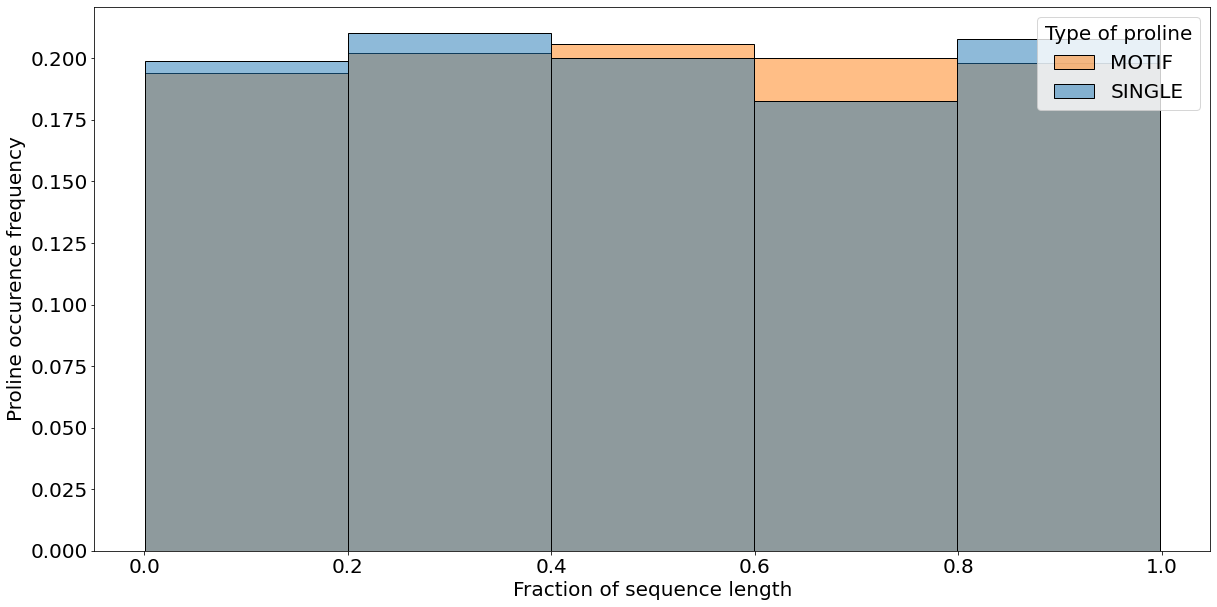

In [26]:
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)

a= sns.histplot(x="positions", hue="type", data=plot_data, bins=5, stat="probability", common_norm=False)
# plt.title("Distribution of polyproline motifs in sequence", size=24)
plt.xlabel("Fraction of sequence length", size=20)
plt.ylabel("Proline occurence frequency", size=20)
plt.legend(["MOTIF", "SINGLE"], title="Type of proline", loc="upper right")

## Does distribution of single prolines differ from distribution of polyproline motifs

In [22]:
motif_distrib_grouped = plot_data.query("type == 'Motif'").positions.value_counts(bins=5, sort=False).values

In [23]:
single_distrib_grouped = plot_data.query("type == 'Single'").positions.value_counts(bins=5, sort=False).values

In [25]:
stat = chi2_contingency(np.array([motif_distrib_grouped, single_distrib_grouped]))
print(f"Chi-square = {stat[0]:.2f}, p-value = {stat[1]:.2f}, df = {stat[2]}")

Chi-square = 4.94, p-value = 0.29, df = 4


Distribution of polyproline motifs in sequence **does not significantly differ** from distribution of polyproline motif positions.

## Do polyproline motifs overlap with secondary structures?

In [46]:
helix_overlaps = []
strand_overlaps = []
turn_overlaps = []
total_helix = []
total_strand = []
total_turn = []

for data, record in proline_feature_map_generator("data/uniprot-proteome_UP000000625.txt"):
    helix_overlaps.append(count_bitmask_seqs(polyproline_overlap_mask(data, "HELIX")))
    total_helix.append(len(list(filter(lambda x: x.type == "HELIX", record.features))))
    
    strand_overlaps.append(count_bitmask_seqs(polyproline_overlap_mask(data, "STRAND")))
    total_strand.append(len(list(filter(lambda x: x.type == "STRAND", record.features))))
    
    turn_overlaps.append(count_bitmask_seqs(polyproline_overlap_mask(data, "TURN")))
    total_turn.append(len(list(filter(lambda x: x.type == "TURN", record.features))))

In [47]:
print(f"{sum(helix_overlaps) / sum(total_helix) * 100:.2f}% of helices overlap with polyproline motifs")

1.84% of helices overlap with polyproline motifs


In [48]:
print(f"{sum(strand_overlaps) / sum(total_strand) * 100:.2f}% of strands overlap with polyproline motifs")

1.15% of strands overlap with polyproline motifs


In [49]:
print(f"{sum(turn_overlaps) / sum(total_turn) * 100:.2f}% of turns overlap with polyproline motifs")

6.14% of turns overlap with polyproline motifs


In [56]:
disord_motif_rel_positions = []
for feature_map, record in proline_feature_map_generator("data/uniprot-proteome_UP000000625.txt"):
    disord_motif_rel_positions += get_rel_pp_position_disord(record)

Text(0, 0.5, 'Motif occurrence frequency')

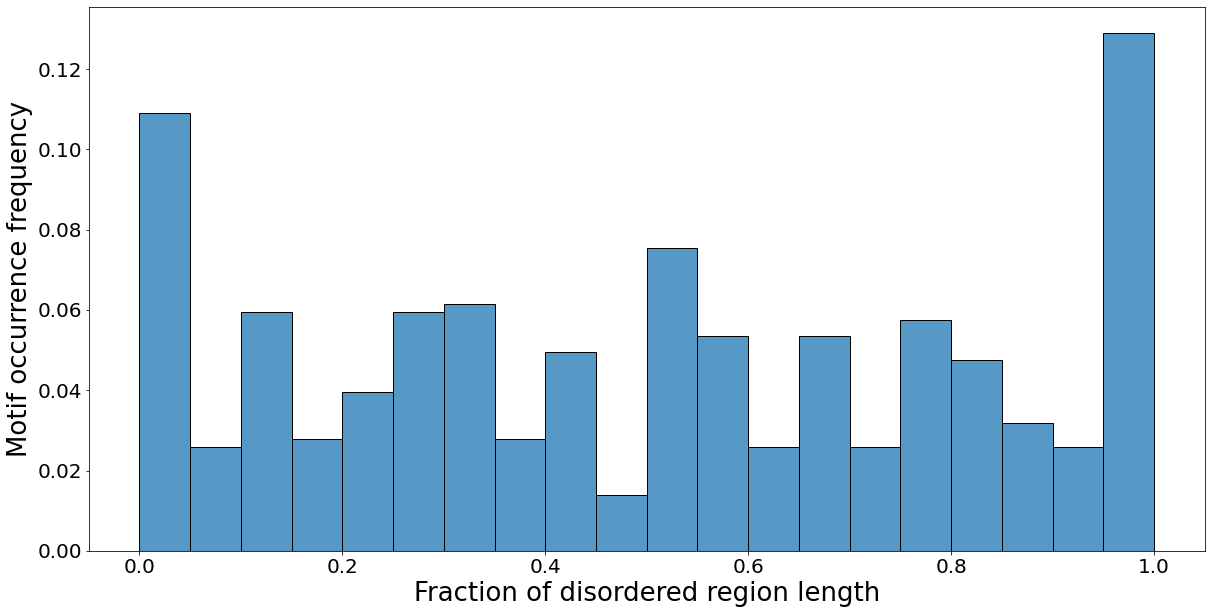

In [57]:
plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=20)

sns.histplot(disord_motif_rel_positions, bins=20, stat="probability")
plt.xlabel("Fraction of disordered region length", size=26)
plt.ylabel("Motif occurrence frequency", size=26)

In [27]:
helix_motif_rel_positions = []
for feature_map, record in proline_feature_map_generator("data/uniprot-proteome_UP000000625.txt"):
    helix_motif_rel_positions += get_rel_pp_position(record, "HELIX")

Text(0.5, 1.0, 'Distribution of polyproline motifs in helices')

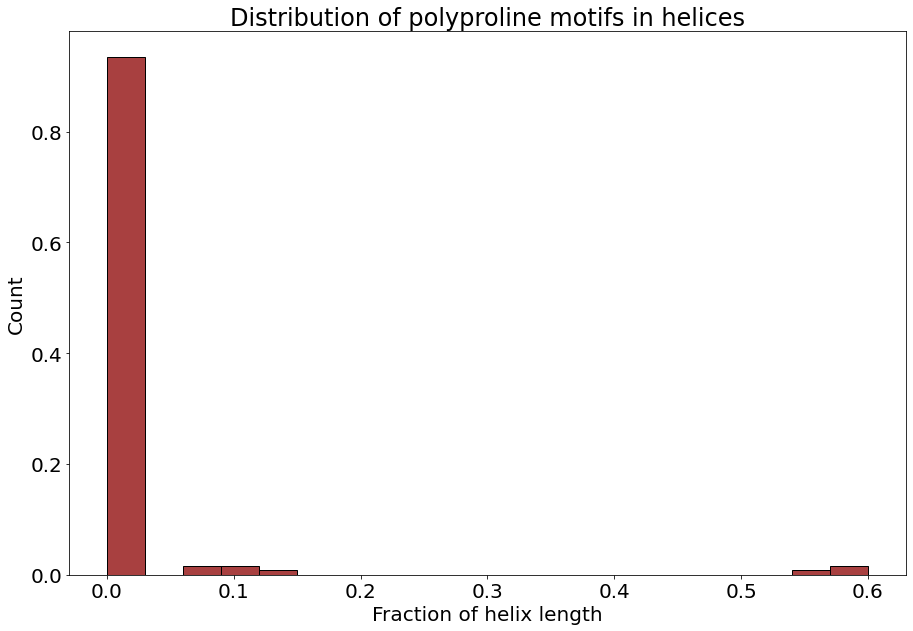

In [28]:
plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=20)

sns.histplot(helix_motif_rel_positions, bins=20, stat="probability", color="darkred")
plt.xlabel("Fraction of helix length", size=20)
plt.ylabel("Count", size=20)
plt.title("Distribution of polyproline motifs in helices", size=24)

In [29]:
strand_motif_rel_positions = []
for feature_map, record in proline_feature_map_generator("data/uniprot-proteome_UP000000625.txt"):
    strand_motif_rel_positions += get_rel_pp_position(record, "STRAND")

Text(0.5, 1.0, 'Distribution of polyproline motifs in strands')

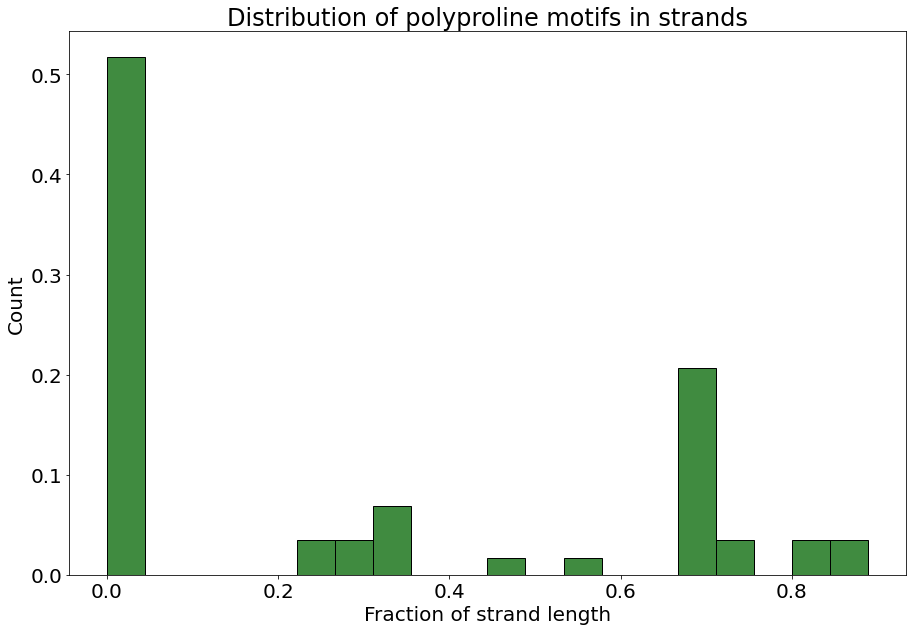

In [30]:
plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=20)

sns.histplot(strand_motif_rel_positions, bins=20, stat="probability", color="darkgreen")
plt.xlabel("Fraction of strand length", size=20)
plt.ylabel("Count", size=20)
plt.title("Distribution of polyproline motifs in strands", size=24)

In [31]:
turn_motif_rel_positions = []
for feature_map, record in proline_feature_map_generator("data/uniprot-proteome_UP000000625.txt"):
    turn_motif_rel_positions += get_rel_pp_position(record, "TURN")

Text(0.5, 1.0, 'Distribution of polyproline motifs in turns')

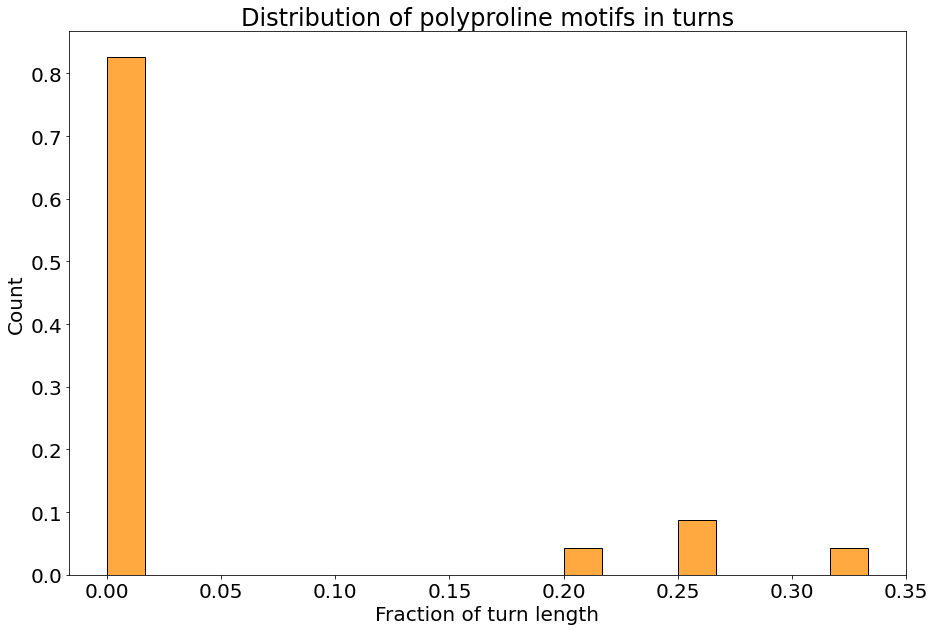

In [32]:
plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=20)

sns.histplot(turn_motif_rel_positions, bins=20, stat="probability", color="darkorange")
plt.xlabel("Fraction of turn length", size=20)
plt.ylabel("Count", size=20)
plt.title("Distribution of polyproline motifs in turns", size=24)

Polyproline motifs overlap with secondary structures very rarely. In these rare cases of overlapping commonly participate first two amino acid residues of the secondary structure. On the other hand distribution of polyproline motifs in disordered regions is not uniform. Polyproline motifs are usually located near flanking secondary structures.